In [53]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# Assignment
Familiarity with several pricing models and how to apply them to a portfolio. Now calculate the VWAP, Sharpe and Alpha for your portfolio from the start of the semester  to the date of you calculations. Your calculation results and the VaR calculations that you performed last week are the main content of the Portfolio Review presentation that is next week's subject and assignment. -- Remember Presentation is Important

# Variables

In [18]:
start_date = datetime(2022, 1, 1)
end_date = datetime.now()
alpha = 0.05
period = '10y'

# Functions

# Load Data

## Load Variables

In [19]:
var_lst = ['^TNX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
rf_rate = round((data.mean() / 100),4)
rf_rate

[*********************100%%**********************]  1 of 1 completed


0.0227

In [20]:
var_lst = ['SPY']
bench_df = pdr.get_data_yahoo(var_lst, period=period)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_df = pd.DataFrame(bench_df)
bench_df.columns = ['SPY']
benchPercent_df = bench_df.pct_change()[1:]
benchPercent_df.head()

[*********************100%%**********************]  1 of 1 completed


,SPY
Date,
2013-10-08,-0.0116
2013-10-09,0.0007
2013-10-10,0.0216
2013-10-11,0.0064
2013-10-14,0.0040


## Load Portfolio

In [21]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w6/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df[['Ticker','BondName','Class','Sub_Class','Price','Shares','Value']]
folio_df.reset_index(inplace=True, drop=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)

#folio_df = folio_df[4:]

portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

print('folio_df: ', folio_df['Value'].sum())

folio_df.head()

folio_df:  83719.0


,Ticker,BondName,Class,Sub_Class,Price,Shares,Value,port_percent
0,IVV,iShares Core S&P 500 ETF,Economically Sensitive,U.S. Equities,448.8456,"8,912.0000","4,000.0000",0.0478
1,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,U.S. Equities,72.2877,"41,501.0000","3,000.0000",0.0358
2,SCHD,Schwab US Dividend Equity ETF™,Economically Sensitive,U.S. Equities,73.1219,"41,027.0000","3,000.0000",0.0358
3,IMCB,iShares Morningstar Mid-Cap ETF,Economically Sensitive,U.S. Equities,62.0215,"64,494.0000","4,000.0000",0.0478
4,VO,Vanguard Mid-Cap ETF,Economically Sensitive,U.S. Equities,216.5903,"9,234.0000","2,000.0000",0.0239


In [22]:
folio_df.groupby(['Class','Sub_Class'])[['Value']].sum()

Value
Class                   Sub_Class                                    
Cash                    Cash                               4,469.0000
Economically Sensitive  Emerging Market Equities           4,000.0000
                        International Equities             8,000.0000
                        Long/Short Equities                2,250.0000
                        Private Equity                     4,200.0000
                        Publicly Traded REITs             10,800.0000
                        U.S. Equities                     21,000.0000
Interest Rate Sensitive U.S. Government Bonds             17,000.0000
                        Very-High-Quality Corporate Bonds  6,000.0000
                        Very-High-Quality Municipal Bonds  6,000.0000

In [23]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83719000.0

In [24]:
a = folio_df.copy()
a['Share_Value'] = a['Price'] * a['Shares']
a

,Ticker,BondName,Class,Sub_Class,Price,Shares,Value,port_percent,Share_Value
0,IVV,iShares Core S&P 500 ETF,Economically Sensitive,U.S. Equities,448.8456,"8,912.0000","4,000.0000",0.0478,"4,000,111.5461"
1,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,U.S. Equities,72.2877,"41,501.0000","3,000.0000",0.0358,"3,000,012.0232"
2,SCHD,Schwab US Dividend Equity ETF™,Economically Sensitive,U.S. Equities,73.1219,"41,027.0000","3,000.0000",0.0358,"2,999,971.3535"
3,IMCB,iShares Morningstar Mid-Cap ETF,Economically Sensitive,U.S. Equities,62.0215,"64,494.0000","4,000.0000",0.0478,"4,000,014.5971"
4,VO,Vanguard Mid-Cap ETF,Economically Sensitive,U.S. Equities,216.5903,"9,234.0000","2,000.0000",0.0239,"1,999,995.2670"
5,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,33.1387,"120,705.0000","4,000.0000",0.0478,"4,000,001.0862"
6,VBR,Vanguard Small-Cap Value ETF,Economically Sensitive,U.S. Equities,163.3983,"6,120.0000","1,000.0000",0.0119,"999,997.8769"
7,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive,International Equities,74.1083,"40,481.0000","3,000.0000",0.0358,"2,999,977.7535"
8,JPEM,JPMorgan Diversified Return EMkts Eq ETF,Economically Sensitive,Emerging Market Equities,50.9158,"78,561.0000","4,000.0000",0.0478,"3,999,998.7186"
9,ISCF,iShares MSCI Intl Small-Cap Mltfct ETF,Economically Sensitive,International Equities,30.6100,"98,007.0000","3,000.0000",0.0358,"2,999,994.3298"


In [25]:
a['Value'].sum()

83719.0

In [26]:
a['Share_Value'].sum()

82719035.99456258

In [27]:
a['check'] = a['Share_Value'] - (a['Value'] * 1000)
a.sort_values(by=['check'], ascending=False)

,Ticker,BondName,Class,Sub_Class,Price,Shares,Value,port_percent,Share_Value,check
0,IVV,iShares Core S&P 500 ETF,Economically Sensitive,U.S. Equities,448.8456,"8,912.0000","4,000.0000",0.0478,"4,000,111.5461",111.5461
33,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,35.2100,"14,201.0000",500.0000,0.0060,"500,017.1969",17.1969
3,IMCB,iShares Morningstar Mid-Cap ETF,Economically Sensitive,U.S. Equities,62.0215,"64,494.0000","4,000.0000",0.0478,"4,000,014.5971",14.5971
1,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,U.S. Equities,72.2877,"41,501.0000","3,000.0000",0.0358,"3,000,012.0232",12.0232
11,VNQ,Vanguard Real Estate ETF,Economically Sensitive,Publicly Traded REITs,80.8038,"40,221.0000","3,250.0000",0.0388,"3,250,010.9675",10.9675
23,VGCAX,Vanguard Global Credit Bond Admiral,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,18.3700,"54,437.0000","1,000.0000",0.0119,"1,000,007.7357",7.7357
29,PEX,ProShares Global Listed Private Equity,Economically Sensitive,Private Equity,27.8600,"150,754.0000","4,200.0000",0.0502,"4,200,006.5320",6.5320
30,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,15.0100,"49,967.0000",750.0000,0.0090,"750,004.6815",4.6815
24,PSAIX,PIMCO Global Advantage Strategy Bd Instl,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,9.6700,"103,413.0000","1,000.0000",0.0119,"1,000,003.7179",3.7179
32,GCHDX,Gotham Hedged Core Institutional,Economically Sensitive,Long/Short Equities,10.8200,"46,211.0000",500.0000,0.0060,"500,003.0057",3.0057


## Load Pricing Time Series

In [28]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']
price_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

price_df['C_A_S_H'] = 1
print('price_df #:', len(price_df.columns))

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No data found, symbol may be delisted')



price_df #: 35
return_df #: 35


In [29]:
print('ticker #:', len(ticker_lst))

ticker #: 35


In [30]:
price_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-07,9.9100,29.9600,20.9800,1,NaN,NaN,NaN,12.3600,NaN,6.9600,...,11.1900,89.8100,11.3300,NaN,22.4700,NaN,66.2000,102.4800,20.0075,NaN
2013-10-08,9.9100,29.4500,21.1800,1,NaN,NaN,NaN,12.2900,NaN,6.9600,...,11.1600,88.6100,11.3200,NaN,22.4600,NaN,65.4800,100.8200,19.6675,NaN
2013-10-09,9.9000,29.4700,21.3400,1,NaN,NaN,NaN,12.3500,NaN,6.9400,...,11.1700,88.3200,11.3100,NaN,22.4400,NaN,65.4900,100.7300,19.6300,NaN
2013-10-10,9.8800,30.1300,21.3500,1,NaN,NaN,NaN,12.5000,NaN,6.9500,...,11.1500,90.2700,11.3000,NaN,22.4200,NaN,67.1600,102.8200,20.0775,NaN
2013-10-11,9.8700,30.2200,21.3800,1,NaN,NaN,NaN,12.5300,NaN,6.9600,...,11.1500,91.3700,11.3100,NaN,22.4500,NaN,67.8300,103.4800,20.2275,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,9.1400,33.8400,14.7800,1,19.1800,22.3300,31.8820,19.4700,10.5400,5.8400,...,9.8200,156.9400,9.5400,17.8600,20.2800,70.5500,74.2700,205.8000,69.0300,47.7100
2023-10-03,9.1100,33.6300,14.7000,1,18.8100,21.8900,31.4580,19.2900,10.4500,5.7900,...,9.7600,154.4600,9.4900,17.7400,20.1100,69.8800,72.8200,202.9400,67.8000,47.5700
2023-10-04,9.1100,33.8200,14.6900,1,19.0300,22.1300,31.6800,19.4000,10.5300,5.8200,...,9.8000,155.0600,9.5300,17.8200,20.2200,70.3800,73.7100,204.5500,68.6900,47.7300


In [31]:
return_df = return_df[1:]
return_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-08,0.0000,-0.0170,0.0095,0.0000,NaN,NaN,NaN,-0.0057,NaN,0.0000,...,-0.0027,-0.0134,-0.0009,NaN,-0.0004,NaN,-0.0109,-0.0162,-0.0170,NaN
2013-10-09,-0.0010,0.0007,0.0076,0.0000,NaN,NaN,NaN,0.0049,NaN,-0.0029,...,0.0009,-0.0033,-0.0009,NaN,-0.0009,NaN,0.0002,-0.0009,-0.0019,NaN
2013-10-10,-0.0020,0.0224,0.0005,0.0000,NaN,NaN,NaN,0.0121,NaN,0.0014,...,-0.0018,0.0221,-0.0009,NaN,-0.0009,NaN,0.0255,0.0207,0.0228,NaN
2013-10-11,-0.0010,0.0030,0.0014,0.0000,NaN,NaN,NaN,0.0024,NaN,0.0014,...,0.0000,0.0122,0.0009,NaN,0.0013,NaN,0.0100,0.0064,0.0075,NaN
2013-10-14,-0.0010,0.0030,0.0000,0.0000,NaN,NaN,NaN,0.0032,NaN,-0.0029,...,0.0000,0.0039,-0.0018,NaN,-0.0018,NaN,0.0006,0.0038,0.0023,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.0033,-0.0044,-0.0027,0.0000,-0.0174,-0.0185,-0.0120,0.0000,-0.0019,-0.0085,...,-0.0071,-0.0160,-0.0052,-0.0050,-0.0078,-0.0109,-0.0184,-0.0117,0.0086,-0.0081
2023-10-03,-0.0033,-0.0062,-0.0054,0.0000,-0.0193,-0.0197,-0.0133,-0.0092,-0.0085,-0.0086,...,-0.0061,-0.0158,-0.0052,-0.0067,-0.0084,-0.0095,-0.0195,-0.0139,-0.0178,-0.0029
2023-10-04,0.0000,0.0056,-0.0007,0.0000,0.0117,0.0110,0.0071,0.0057,0.0077,0.0052,...,0.0041,0.0039,0.0042,0.0045,0.0055,0.0072,0.0122,0.0079,0.0131,0.0034


## Analytics

return_df.corr()

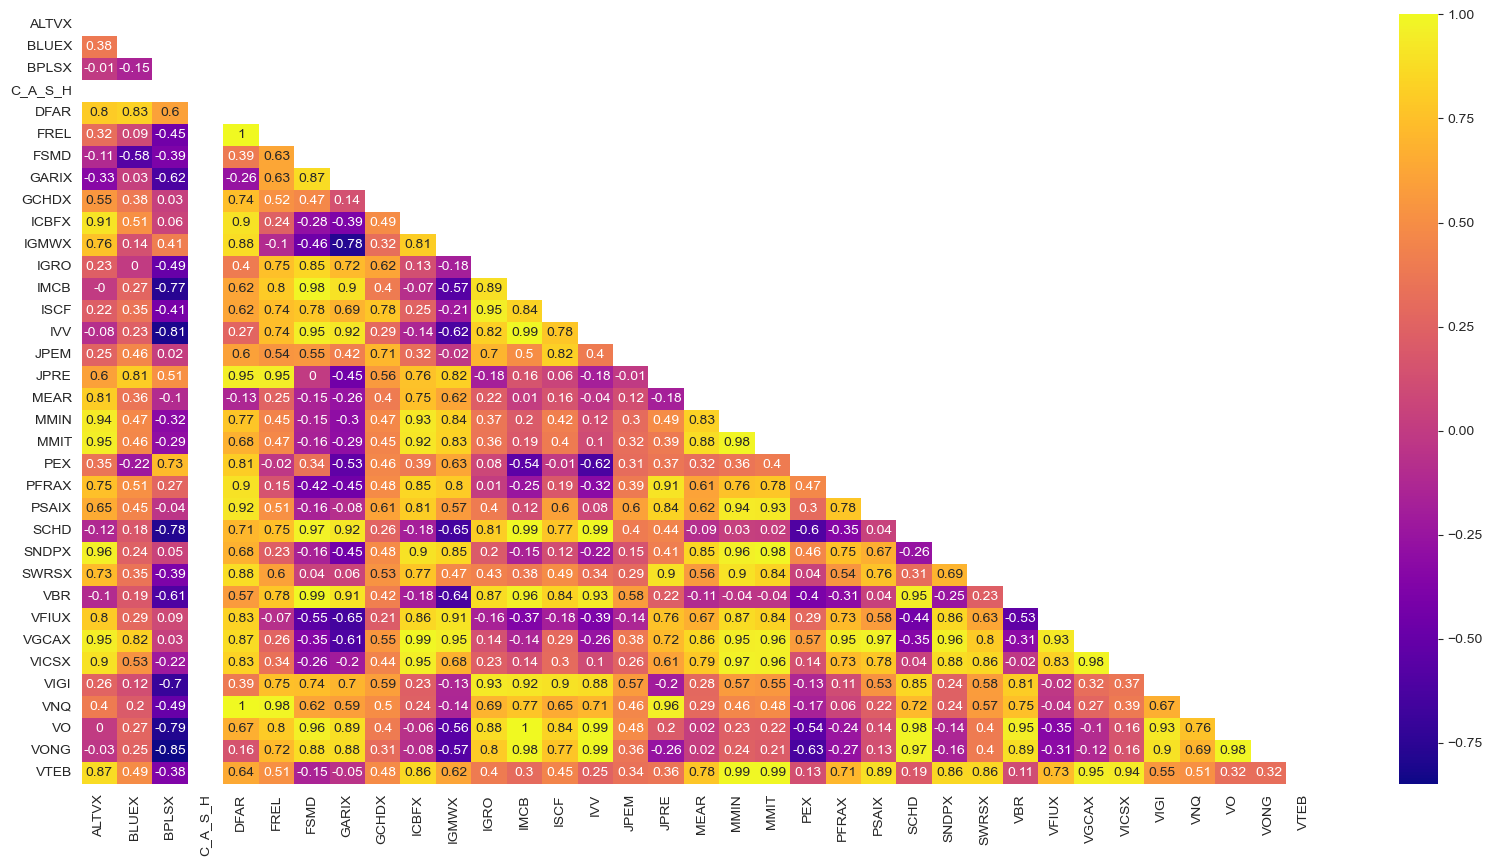

In [32]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

# Calculate Portfolio Value

In [33]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
#shares_df[['Shares']].round(0)
shares_df.head()

,Shares
Ticker,
IVV,"8,912.0000"
VONG,"41,501.0000"
SCHD,"41,027.0000"
IMCB,"64,494.0000"
VO,"9,234.0000"


In [34]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

,Date,Ticker,Price
0,2013-10-07,ALTVX,9.9100
1,2013-10-08,ALTVX,9.9100
2,2013-10-09,ALTVX,9.9000
3,2013-10-10,ALTVX,9.8800
4,2013-10-11,ALTVX,9.8700


In [35]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
l_df.head()

,Ticker,Class,Sub_Class
0,IVV,Economically Sensitive,U.S. Equities
1,VONG,Economically Sensitive,U.S. Equities
2,SCHD,Economically Sensitive,U.S. Equities
3,IMCB,Economically Sensitive,U.S. Equities
4,VO,Economically Sensitive,U.S. Equities


In [36]:
merg_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker').merge(shares_df,how='left' ,left_on='Ticker', right_on='Ticker')
merg_df['share_value'] = merg_df['Price'] * merg_df['Shares']
merg_df.head()

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value
0,2013-10-07,ALTVX,9.9100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,054,255.5138"
1,2013-10-08,ALTVX,9.9100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,054,255.5138"
2,2013-10-09,ALTVX,9.9000,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,053,191.6594"
3,2013-10-10,ALTVX,9.8800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,051,064.0522"
4,2013-10-11,ALTVX,9.8700,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,050,000.1978"


In [38]:
folioValue_df = merg_df.groupby(['Date'])[['share_value']].sum().reset_index()
folioValue_df

,Date,share_value
0,2013-10-07,"48,909,782.3701"
1,2013-10-08,"48,705,968.4141"
2,2013-10-09,"48,632,973.2012"
3,2013-10-10,"48,830,674.6136"
4,2013-10-11,"49,026,868.2323"
...,...,...
2513,2023-10-02,"79,443,848.0453"
2514,2023-10-03,"78,597,476.9912"
2515,2023-10-04,"78,961,375.6978"
2516,2023-10-05,"79,085,850.6373"


In [39]:
a = merg_df[merg_df['Date'] == '2023-09-11']
#.to_csv('./data/tmp.csv', index=False)
#a['share_value'].sum()
#a

In [40]:
folioValue_df[folioValue_df['Date'] == '2023-09-11']

,Date,share_value
2498,2023-09-11,"83,004,840.7077"


In [41]:
folioValue_df[folioValue_df['Date'] == '2023-10-06']

,Date,share_value
2517,2023-10-06,"79,376,544.6729"


In [62]:
folioValue_df['pct_change'] = folioValue_df['share_value'].pct_change()
folioValue_df = folioValue_df[1:]
folioValue_df

,Date,share_value,pct_change
1,2013-10-08,"48,705,968.4141",-0.0042
2,2013-10-09,"48,632,973.2012",-0.0015
3,2013-10-10,"48,830,674.6136",0.0041
4,2013-10-11,"49,026,868.2323",0.0040
5,2013-10-14,"49,043,811.1265",0.0003
...,...,...,...
2513,2023-10-02,"79,443,848.0453",-0.0088
2514,2023-10-03,"78,597,476.9912",-0.0107
2515,2023-10-04,"78,961,375.6978",0.0046
2516,2023-10-05,"79,085,850.6373",0.0016


In [42]:
t_df = merg_df.groupby(['Date','Class','Sub_Class'])[['share_value']].sum().reset_index()
t_df

,Date,Class,Sub_Class,share_value
0,2013-10-07,Cash,Cash,"4,469,000.0000"
1,2013-10-07,Economically Sensitive,Emerging Market Equities,0.0000
2,2013-10-07,Economically Sensitive,International Equities,0.0000
3,2013-10-07,Economically Sensitive,Long/Short Equities,"1,786,205.6554"
4,2013-10-07,Economically Sensitive,Private Equity,"6,575,889.3190"
...,...,...,...,...
25175,2023-10-06,Economically Sensitive,Publicly Traded REITs,"9,966,709.3909"
25176,2023-10-06,Economically Sensitive,U.S. Equities,"20,132,642.5854"
25177,2023-10-06,Interest Rate Sensitive,U.S. Government Bonds,"16,478,303.8588"
25178,2023-10-06,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"4,862,725.4654"


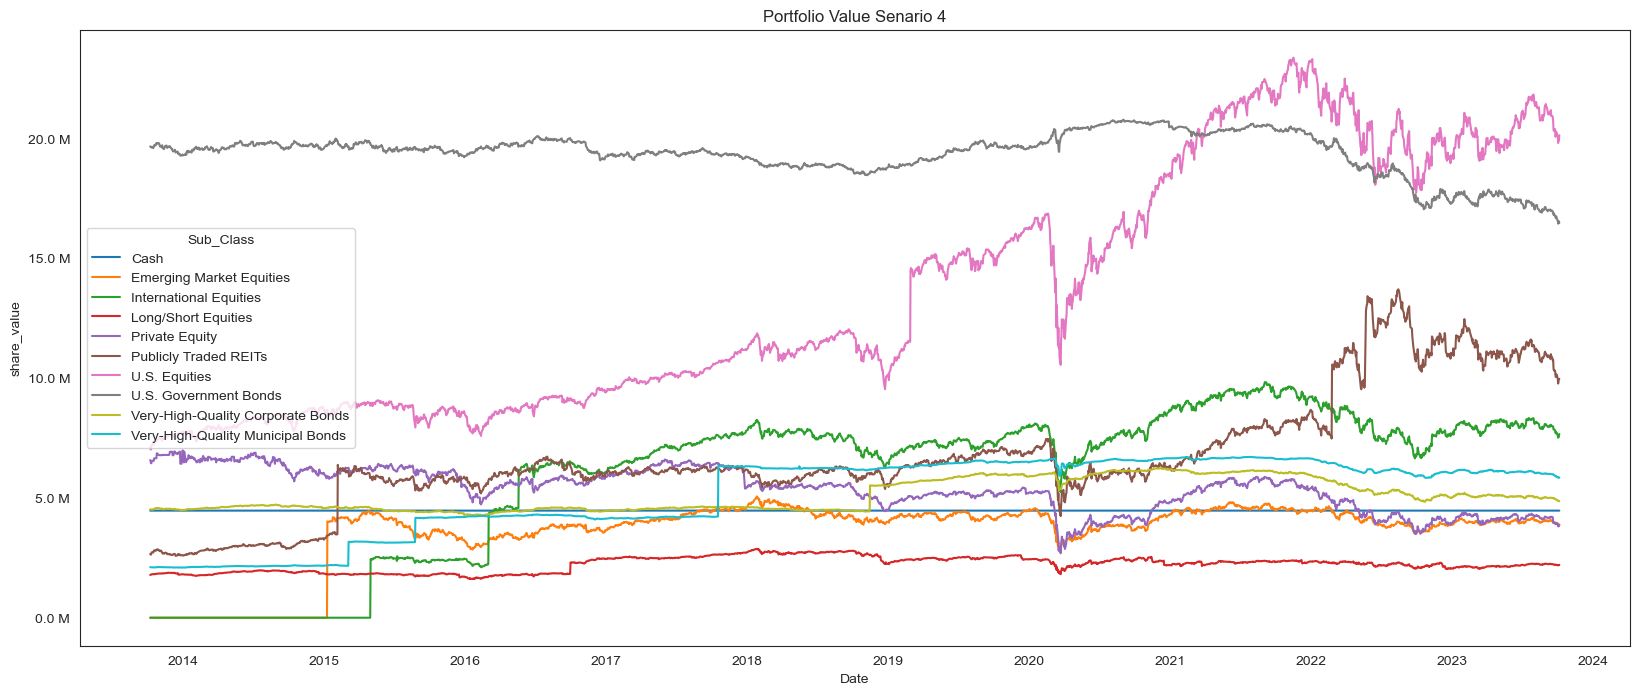

In [43]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="share_value", hue='Sub_Class')
g.set_yticklabels(['{:,.1f}'.format(x) + ' M' for x in g.get_yticks()/1000000])

ax.set(title='Portfolio Value Senario 4');

# Alpha Calculations

In [50]:
def alpha(portfolio_returns, benchmark_returns):
    # mean of the return
    portfolio_avg_return = np.mean(portfolio_returns)
    benchmark_avg_return = np.mean(benchmark_returns)
    
    # volatility
    portfolio_volatility = np.std(portfolio_returns)
    benchmark_volatility = np.std(benchmark_returns)
    
    # our alpha
    alpha = (portfolio_avg_return - benchmark_avg_return) / (portfolio_volatility / benchmark_volatility)
    
    return alpha


def linreg(x,y):
    x = sm.add_constant(x) # add a column of 1s to our data (for intercept)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1] # remove the constant
    return model.params[0], model.params[1]

In [45]:
return_df.columns

Index(['ALTVX', 'BLUEX', 'BPLSX', 'C_A_S_H', 'DFAR', 'FREL', 'FSMD', 'GARIX',
       'GCHDX', 'ICBFX', 'IGMWX', 'IGRO', 'IMCB', 'ISCF', 'IVV', 'JPEM',
       'JPRE', 'MEAR', 'MMIN', 'MMIT', 'PEX', 'PFRAX', 'PSAIX', 'SCHD',
       'SNDPX', 'SWRSX', 'VBR', 'VFIUX', 'VGCAX', 'VICSX', 'VIGI', 'VNQ', 'VO',
       'VONG', 'VTEB'],
      dtype='object')

In [65]:
X = benchPercent_df['SPY'].values
Y = folioValue_df['pct_change'].values

In [66]:
alpha, beta = linreg(X,Y)
historical_beta = beta

In [67]:
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: 1.9410382280079505e-05
beta: 0.43857134578655116


# Economically Sensitive

In [ ]:
tickers='^DJA'
#tickers = 'FHNFX'
DJA = pdr.get_data_yahoo(tickers=tickers, period=period)
return_econ_df['Benchmark']= DJA['Close']
return_econ_df['Benchmark']= return_econ_df['Benchmark'].pct_change(1) #.dropna()
#return_df= return_df.dropna()
print('return_econ_df #:', return_econ_df.shape)

# Interest Rate Sensitive

In [ ]:
#tickers='^DJA'
tickers = 'FHNFX'
DJA = pdr.get_data_yahoo(tickers=tickers, period=period)
return_int_df['Benchmark']= DJA['Close']
return_int_df['Benchmark']= return_int_df['Benchmark'].pct_change(1)

print('return_int_df #:', return_int_df.shape)

In [ ]:
ticker_lst = 